## Ajuste por maximización de Posterior

In [2]:
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import corner

In [3]:
data = np.load('fnumpy.npy') #Cargamos el archivo de datos
n = len(data[0])
va = np.var(data[1])
prior = np.log(1/(max(data[0])-min(data[0])))                              #Aquí se define el prior PLANO

### Los datos usados están compuestos de un arreglo de 3 subarreglos de 50 mediciones, donde el primer subarreglo son los datos de $x$, el segundo son de $y$ y el tercero son los errores en $y$

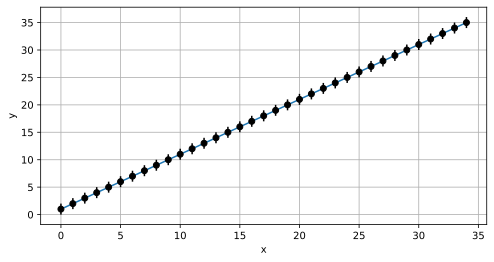

In [4]:
#plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (8,4)
plt.errorbar(data[0], data[1], yerr=1, xerr = 0, fmt='o', color="black")
plt.plot(data[0],data[0]+1)
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

## Los datos aparentan ajustarse con una función lineal $ax + b$. Se usará el likelihood gaussiano, encontrando el valor de los parámetros que lo maximiza.
## Lo que buscamos es el posterior:
## $P(y,\theta) \propto P(y|\theta)P(\theta)$ donde $P(y|\theta)$ es el likelihood y $P(\theta)$ es el prior, que para este caso será plano y se calculará:
## $P(\theta) = \frac{1}{b-a}$
## y el likelihood:
## $\mathbf{L} \; \propto \; \prod_{i}^{n}\frac{1}{\sqrt{2\pi \sigma^2}} e^{-\frac{(y_i-\lambda(x_i,\theta))^2}{2\sigma^2}}$
## $\ln{(\mathbf{L})} \; \propto \; -\frac{-n}{2}\ln{(2\pi \sigma^2)}-\frac{1}{2\sigma^2}\sum_i^n(y_i-\lambda(x_i,\theta))^2$
### Donde $\lambda(x_i,\theta)$ es el modelo y $\sigma^2$ la varianza de los $y_i$
## Entonces calcularemos:
## $\ln{P(y,\theta)} \propto \ln{P(y|\theta)} + \ln{P(\theta)}$

In [5]:
def posterior(w):
    llt = 0
    ll = -(n/2)*np.log(2*np.pi*va)
    for i in range (n):
        fx = data[0,i]*w[0] + w[1]             #Aquí va el modelo
        llt+= -(data[1,i]-fx)**2
    ll += (1/(2*va))*llt + prior
    return ll

In [6]:
def metropolis(mm,camt):
    cami = np.array([[camt[0,0],camt[0,1]]])
    aux,aux2 = cami[0,0],cami[0,1]
    tt = posterior(camt[0])
    for j in range (mm-1):
        irma = np.random.normal(loc=aux, scale=0.1)        #Aquí se calculan números aleatorios de
        kari = np.random.normal(loc=aux2, scale=0.3)       #Distribución normal centrada en los valores iniciales
        camt[j+1] = np.array([irma,kari])                  #Cada par de valores se guarda en estos arreglos                                                
        ttn = posterior(camt[j+1])
        if ttn>tt:
            cami = np.append(cami,[[irma,kari]],axis=0)    #Solo los exitosos se guardan en este arreglo 
            aux,aux2 = irma,kari                           #Para graficarlo después
            tt = ttn
        else:
            ran = np.log(np.random.uniform(low=0.0, high=1.0))     #"Volado"
            if (ttn-tt) > ran:
                cami = np.append(cami,[[irma,kari]],axis=0)
                aux,aux2 = irma,kari
                tt = ttn
    return cami,camt

In [7]:
def caminante(nn):
    cam = np.zeros((5,m,2))                    #((numero de caminantes,m,número de parámetros))
    cam[0] = np.array([0,0])
    cam[1] = np.array([0,-1])
    cam[2] = np.array([0,2])
    cam[3] = np.array([-1,0])
    cam[4] = np.array([-1,-1])    
    camin1,cam[0] = metropolis(nn,cam[0])
    camin2,cam[1] = metropolis(nn,cam[1])
    camin3,cam[2] = metropolis(nn,cam[2])
    camin4,cam[3] = metropolis(nn,cam[3])
    camin5,cam[4] = metropolis(nn,cam[4])
    return camin1,camin2,camin3,camin4,camin5,cam

In [8]:
m = 20000                               #número de intentos de pasos del caminante
cam,cam2,cam3,cam4,cam5,camtt = caminante(m)

In [9]:
glob = np.vstack((cam,cam2,cam3,cam4,cam5))
print(len(glob)/(m*5))

0.65984


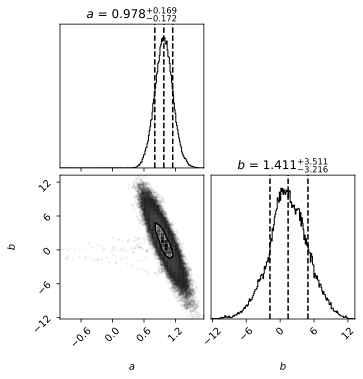

In [10]:
figure = corner.corner(glob, 
                       bins=40,hist_bin_factor=5,
                       labels=[r"$a$", r"$b$"],       #Compara los parametros con un arreglo de formato = [[a1,b1],[a2,b2]...]
                       title_fmt='.3f',
                       quantiles=[0.16, 0.5, 0.84],         #sigmas
                       levels=(1-np.exp(-0.5),),            #sigma bidimensional
                       show_titles=True, title_kwargs={"fontsize": 12})

## Diagnóstico de Gelman-Rubin
### Método para comprobar convergencia de la cadena
## $\hat{R} = \sqrt{\frac{\hat{\sigma}^2}{s^2}}$ Cuando $R\leq \delta$ para un $\delta>1$, la cadena podría converger.
### Donde: 
# $\hat{\sigma}^2 = \frac{n-1}{n}s^2+\frac{B}{n}$
# $\frac{B}{n} = \frac{1}{m-1}\sum_{i=1}^m (\bar{X}_i-\hat{\mu})^2$
# $s^2 = \frac{1}{m}\sum_{i=1}^m s_i^2$
# $s_i^2 = \frac{1}{n-1}\sum_{t=1}^n(X_{it}-\bar{X}_i)^2$
## $\bar{X_i} = $ media para la cadena $i$ para un parámetro dado
## $n = $ Muestras para cada cadena
## $m = $ Número de cadenas
## $\hat{\mu} = $ Valor promedio para cada parámetro (Promedio de los promedios)


In [13]:
s,me,R = np.zeros((5,2)),np.zeros((5,2)),np.zeros((5,2))
s[0],me[0] = np.var(cam,axis=0,ddof=1),np.mean(cam,axis=0)
s[1],me[1] = np.var(cam2,axis=0,ddof=1),np.mean(cam2,axis=0)
s[2],me[2] = np.var(cam3,axis=0,ddof=1),np.mean(cam3,axis=0)
s[3],me[3] = np.var(cam4,axis=0,ddof=1),np.mean(cam4,axis=0)
s[4],me[4] = np.var(cam5,axis=0,ddof=1),np.mean(cam5,axis=0)
st = np.mean(s**2,axis=0)
for i in range(2):
    R[0,i] = np.sqrt(((((len(cam)-1)/len(cam))*st[i])+ np.var(me,axis=0,ddof=1)[i])/st[i])
    R[1,i] = np.sqrt(((((len(cam2)-1)/len(cam2))*st[i])+ np.var(me,axis=0,ddof=1)[i])/st[i])
    R[2,i] = np.sqrt(((((len(cam3)-1)/len(cam3))*st[i])+ np.var(me,axis=0,ddof=1)[i])/st[i])
    R[3,i] = np.sqrt(((((len(cam4)-1)/len(cam4))*st[i])+ np.var(me,axis=0,ddof=1)[i])/st[i])
    R[4,i] = np.sqrt(((((len(cam5)-1)/len(cam5))*st[i])+ np.var(me,axis=0,ddof=1)[i])/st[i])
R

array([[1.72184284, 1.00368069],
       [1.721843  , 1.00368095],
       [1.72184282, 1.00368065],
       [1.72184298, 1.00368093],
       [1.72184286, 1.00368071]])